# Код для инференса модели

Топ-1 предсказание: Динамо, Вероятность: 0.9988881945610046
Топ-2 предсказание: Центральный стадион, Вероятность: 0.0003539769968483597
Топ-3 предсказание: Малышеву, Вероятность: 0.00018804875435307622
Топ-4 предсказание: Уральский турбинный завод, Вероятность: 0.00015509103832300752
Топ-5 предсказание: Владимирский государственный гуманитарный университет, Вероятность: 0.00012100005551474169


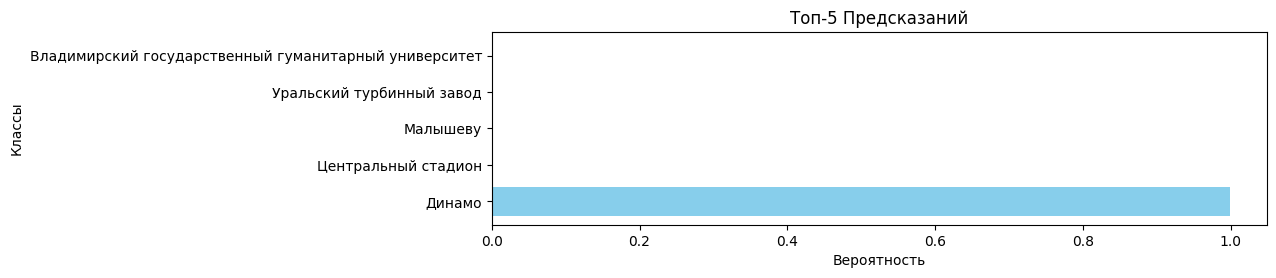

In [ ]:
import torch
import torchvision.transforms as transforms
import joblib
import matplotlib.pyplot as plt


from torchvision import models
from PIL import Image

image_path = 'test_image.jpg'
image = Image.open(image_path)
# image = images[0]

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
input_tensor = test_transform(image).unsqueeze(0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)

model_weights_path = '/content/resnet_101.pth'
label_encoder_path = 'label_encoder.pkl'

model = models.resnet101()
model.fc = torch.nn.Linear(model.fc.in_features, 387)
model.load_state_dict(torch.load(model_weights_path))
model = model.to(device)

label_encoder = joblib.load(label_encoder_path)

model.eval()

with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.topk(outputs, 5)


predicted_indexes = predicted.cpu().numpy()[0]
probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[0][predicted_indexes]

predicted_labels = label_encoder.inverse_transform(predicted_indexes)
for i in range(len(predicted_labels)):
    print(f"Топ-{i+1} предсказание: {predicted_labels[i]}, Вероятность: {probabilities[i]}")


plt.figure(figsize=(10, len(predicted_indexes)*0.5))
plt.barh(range(len(predicted_indexes)), probabilities, color='skyblue')
plt.xlabel('Вероятность')
plt.ylabel('Классы')
plt.title('Топ-5 Предсказаний')
plt.yticks(range(len(predicted_indexes)), predicted_labels)
plt.show()